In [1]:
from tqdm import tqdm 

import os

import numpy as np

import torch
import torch.nn as nn

from torch.optim import Adam

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
from torchvision.utils import save_image, make_grid

from unet import Unet
from scheduler import get_schedules

In [2]:
# Hyper parameters

epochs = 20  # If training takes too long you can reduce the number of epochs or increase the batch size
batch_size = 64
lr = 1e-5

n_T = 1000
betas = [1e-4, 0.02]

In [3]:
torch.manual_seed(42)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# Import dataset
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])
dataset = MNIST("./data", train=True, download=True, transform=transform,
)

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

In [5]:
# Initialize model, loss function, and optimizer
unet = Unet(n_features=128).to(device)
loss_fn = nn.MSELoss()
optim = Adam(unet.parameters(), lr=lr)

# pre-compute schedules
schedules = get_schedules(betas[0], betas[1], n_T)
schedules = {key: val.to(device) for key, val in schedules.items()}  # add all tensors on device

In [6]:
# Create results directory if it does not exist
if not os.path.isdir('results'):
    os.makedirs('results')

if not os.path.isdir('saved_models'):
    os.makedirs('saved_models')

In [7]:
# Sampling function (used to log the results)
def sample(model, n_T, n_samples, sample_shape, device, schedules):

    # Step 1
    x_T = torch.randn(n_samples, *sample_shape).to(device)
    ones = torch.ones(n_samples).to(device)

    # Step 2
    x_i = x_T
    for i in tqdm(range(n_T, 0, -1)):
        # Step 3
        z = torch.randn(n_samples, *sample_shape).to(device) if i > 1 else 0
        # Step 4
        t = (i / n_T)*ones
        eps = model(x_i, t)
        eps = eps.clone().detach()
        v = schedules["one_over_sqrt_a"][i] * (x_i - eps * schedules["inv_alpha_over_sqrt_inv_abar"][i])
        x_i = v + schedules["sqrt_beta"][i] * z


    # Step 6
    x = x_i
    return x

In [8]:
# Training loop
losses = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} : ")

    # Set unet in training mode
    unet.train()

    pbar = tqdm(dataloader)
    for x, _ in pbar:
        x = x.to(device)
        x = x.view(-1, 1, 28, 28)

        # Step 3
        timesteps = torch.randint(1, n_T + 1, (x.shape[0],)).to(device)

        # Step 4
        eps = torch.randn_like(x)

        # Step 5
        optim.zero_grad()

        x_t = schedules["sqrt_abar"][timesteps, None, None, None] * x + schedules["sqrt_inv_abar"][timesteps, None, None, None] * eps
        t = timesteps/n_T
        eps_hat = unet(x_t, t)


        loss = loss_fn(eps_hat, eps)
        loss.backward()
        losses.append(loss.item())
        avg_loss = np.asarray(losses)[-10:].mean()
        pbar.set_description(f"Moving average loss: {avg_loss:.4f}")
        optim.step()

    # Set unet in eval mode
    unet.eval()
    with torch.no_grad():
        x_hat = sample(unet, n_T, 8, (1, 28, 28), device, schedules)
        grid = make_grid(x_hat, normalize=True, value_range=(-1, 1), nrow=4)

        # IMPORTANT: the grid contains 
        save_image(grid, f"results/sample_mnist{epoch+1}.png")

        # save model
        torch.save(unet.state_dict(), f"saved_models/unet_mnist.pt")

Epoch 1 : 


100%|██████████| 1000/1000 [00:04<00:00, 231.95it/s]


Epoch 2 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.52it/s]


Epoch 3 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.36it/s]


Epoch 4 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.51it/s]


Epoch 5 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.50it/s]


Epoch 6 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.62it/s]


Epoch 7 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.21it/s]


Epoch 8 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.20it/s]


Epoch 9 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.38it/s]


Epoch 10 : 


100%|██████████| 1000/1000 [00:04<00:00, 232.36it/s]


Epoch 11 : 


Moving average loss: 0.0507:  22%|██▏       | 207/938 [00:20<01:12, 10.13it/s]


KeyboardInterrupt: 

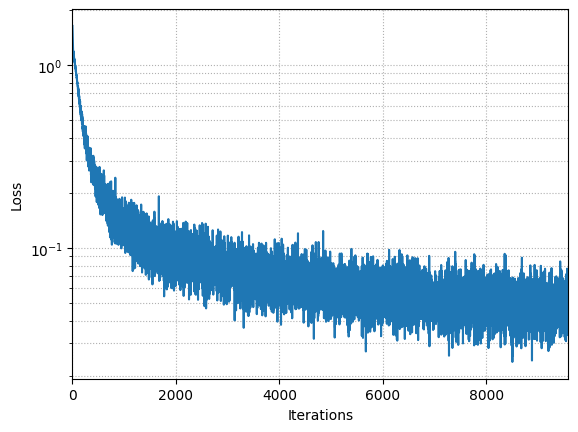

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.semilogy(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.xlim([0, len(losses)])
plt.grid(linestyle=':', which='both')
plt.draw()
plt.show()